# Deep Learning Term Project for ECG (DIL700)

# Iteration 3

## Imports

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import class_weight
import warnings
import os
from general_functions import *
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


warnings.filterwarnings('ignore')

## Loading Dataset

Collect all the data from the csv files

In [2]:
train_df=combine_csv_files_to_df('./Dataset_mitbih/Training/')
test_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# Put together the training and testing
full_df=pd.concat([train_df,test_df],ignore_index=True)


## Removing class 3 and renaming class 4 to class 3

In [3]:
train_df = train_df[train_df[187] != 3]
test_df = test_df[test_df[187] != 3]
full_df = full_df[full_df[187] != 3]

train_df.loc[train_df[187] == 4, 187] = 3
test_df.loc[test_df[187] == 4, 187] = 3
full_df.loc[full_df[187] == 4, 187] = 3


In [4]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [5]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [6]:
print(train_df[187].unique())

[0. 1. 2. 3.]


In [7]:
labels = ['Normal', 'Artial Premature', 'Premature ventricular contraction', 'Paced']
labels_short =  ["N","S","V","Q"]

In [8]:
print('Number of samples in data:')
print(labels[0],':', len(train_df[train_df[187]==0]))
print(labels[1],':', len(train_df[train_df[187]==1]))
print(labels[2],':', len(train_df[train_df[187]==2]))
print(labels[3],':', len(train_df[train_df[187]==3]))

Number of samples in data:
Normal : 72471
Artial Premature : 2223
Premature ventricular contraction : 5788
Paced : 6431


In [9]:
print('Number of samples in data:')
print(labels[0],':', len(test_df[test_df[187]==0]))
print(labels[1],':', len(test_df[test_df[187]==1]))
print(labels[2],':', len(test_df[test_df[187]==2]))
print(labels[3],':', len(test_df[test_df[187]==3]))

Number of samples in data:
Normal : 18118
Artial Premature : 556
Premature ventricular contraction : 1448
Paced : 1608


## Preparation

In [10]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=82)

y_train_nn = pd.get_dummies(y_train, columns=[1])
y_train_nn = y_train_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

y_valid_nn = pd.get_dummies(y_valid, columns=[1])
y_valid_nn = y_valid_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]
y_test_nn = pd.get_dummies(y_test, columns=[1])
y_test_nn = y_test_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

In [11]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
28367,0.989610,0.888312,0.425974,0.049351,0.096104,0.124675,0.101299,0.093506,0.096104,0.090909,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62622,1.000000,0.954751,0.266968,0.000000,0.063348,0.099548,0.104072,0.176471,0.153846,0.126697,...,0.298643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3227,1.000000,0.942431,0.686567,0.422175,0.321962,0.268657,0.179104,0.138593,0.149254,0.147122,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57171,1.000000,0.875831,0.170732,0.000000,0.106430,0.137472,0.128603,0.119734,0.113082,0.099778,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69122,1.000000,0.773333,0.053333,0.073333,0.090000,0.093333,0.086667,0.093333,0.083333,0.086667,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38510,0.975357,0.941634,0.498054,0.000000,0.068742,0.125811,0.057069,0.050584,0.044099,0.040208,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19805,0.990672,0.777985,0.139925,0.037313,0.098881,0.102612,0.115672,0.111940,0.110075,0.123134,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41091,1.000000,0.905405,0.705405,0.354054,0.170270,0.124324,0.102703,0.059459,0.062162,0.037838,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4546,1.000000,0.510791,0.000000,0.089928,0.089928,0.118705,0.111511,0.115108,0.097122,0.107914,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
y_train

28367    0.0
62622    0.0
3227     0.0
57171    0.0
69122    0.0
        ... 
38510    0.0
19805    0.0
41091    0.0
4546     0.0
77955    2.0
Name: 187, Length: 69530, dtype: float64

In [13]:
X_valid

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
14772,0.964912,0.912281,0.583960,0.273183,0.147870,0.120301,0.092732,0.060150,0.050125,0.030075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49137,0.987080,0.953488,0.731266,0.253230,0.069767,0.139535,0.103359,0.038760,0.012920,0.025840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31361,0.000000,0.294118,0.745098,0.281046,0.117647,0.372549,0.588235,0.575163,0.633987,0.620915,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60850,0.817021,0.646809,0.178723,0.051064,0.085106,0.136170,0.131915,0.229787,0.234043,0.136170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64495,1.000000,0.890966,0.520249,0.261682,0.168224,0.161994,0.118380,0.099688,0.074766,0.087227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45252,0.993661,0.801902,0.193344,0.000000,0.215531,0.213946,0.221870,0.231379,0.231379,0.225040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61241,1.000000,0.789256,0.107438,0.012397,0.097107,0.088843,0.070248,0.057851,0.047521,0.051653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30540,1.000000,0.695946,0.087838,0.020270,0.077703,0.094595,0.097973,0.091216,0.091216,0.087838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86618,1.000000,0.854054,0.578378,0.370270,0.275676,0.300000,0.291892,0.308108,0.297297,0.305405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dataset Distribution

### Training set

In [14]:
train_df[187]=train_df[187].astype(int)
equilibre_train=train_df[187].value_counts(sort=False)
print(equilibre_train)

0    72471
1     2223
2     5788
3     6431
Name: 187, dtype: int64


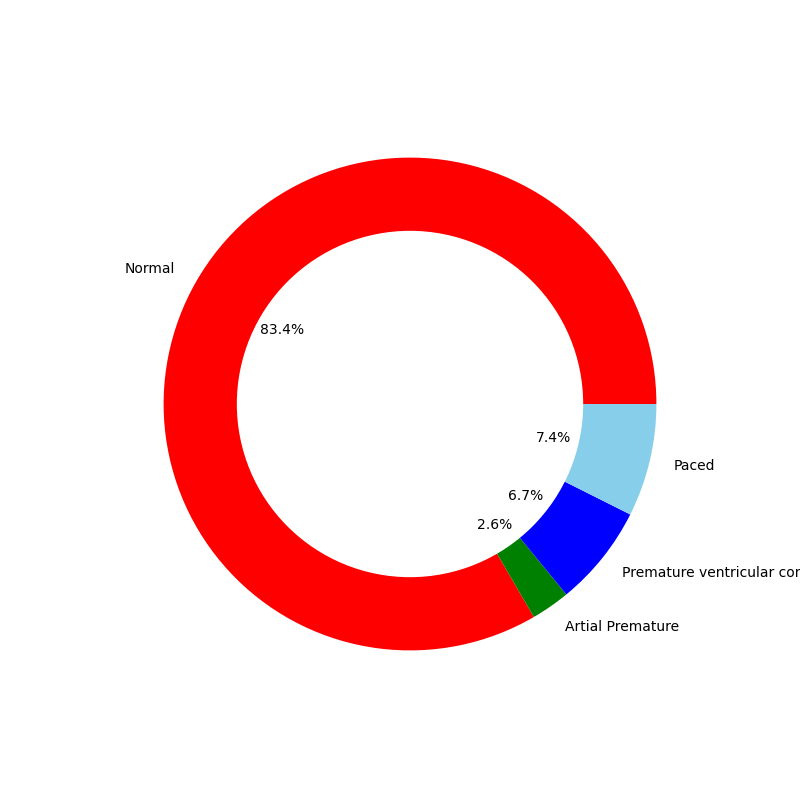

In [15]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_train, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Testing set

In [16]:
test_df[187]=test_df[187].astype(int)
equilibre_test=test_df[187].value_counts(sort=False)
print(equilibre_test)

0    18118
1      556
2     1448
3     1608
Name: 187, dtype: int64


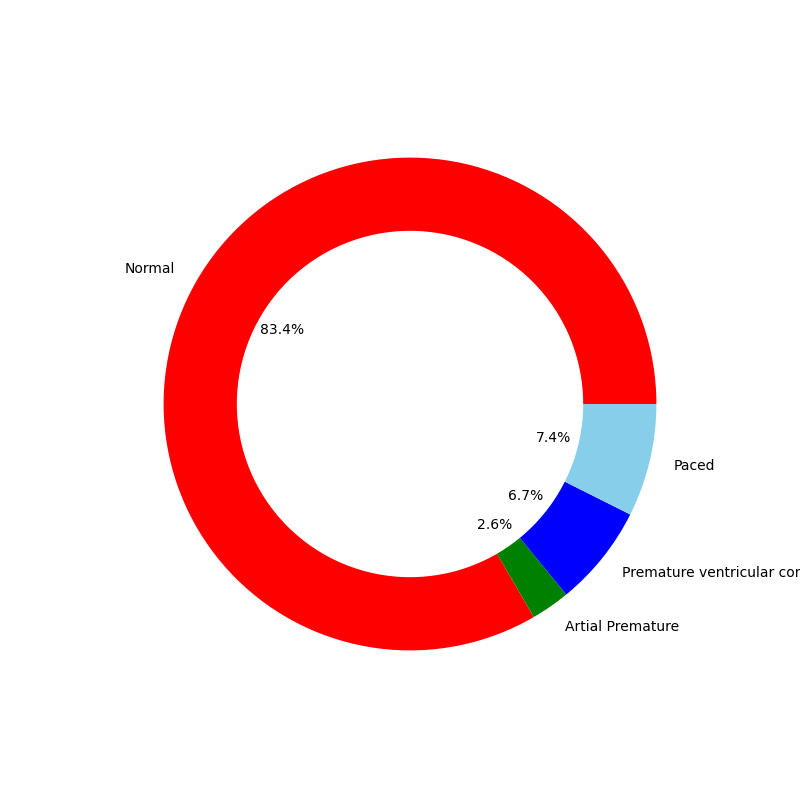

In [17]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_test, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Simple ANN

In [19]:
model_ann = Sequential([
    Dense(256, activation='relu', input_dim=(X_train.shape[1])),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model_ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_ann_5.h5', monitor='val_loss', save_best_only=True)]


history_ann = model_ann.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))
model_ann.load_weights('best_ann_5.h5')
save_model(model_ann, 'Simple_ANN_MITBIH', 'keras')

Epoch 1/40
2173/2173 [==============================] - 6s 3ms/step - loss: 0.2054 - accuracy: 0.9419 - val_loss: 0.1263 - val_accuracy: 0.9636
Epoch 2/40
2173/2173 [==============================] - 5s 2ms/step - loss: 0.1201 - accuracy: 0.9658 - val_loss: 0.1152 - val_accuracy: 0.9682
Epoch 3/40
2173/2173 [==============================] - 5s 2ms/step - loss: 0.1011 - accuracy: 0.9716 - val_loss: 0.0922 - val_accuracy: 0.9746
Epoch 4/40
2173/2173 [==============================] - 6s 3ms/step - loss: 0.0875 - accuracy: 0.9747 - val_loss: 0.0933 - val_accuracy: 0.9745
Epoch 5/40
2173/2173 [==============================] - 7s 3ms/step - loss: 0.0811 - accuracy: 0.9764 - val_loss: 0.0972 - val_accuracy: 0.9723
Epoch 6/40
2173/2173 [==============================] - 5s 2ms/step - loss: 0.0739 - accuracy: 0.9780 - val_loss: 0.0802 - val_accuracy: 0.9768
Epoch 7/40
2173/2173 [==============================] - 5s 2ms/step - loss: 0.0673 - accuracy: 0.9801 - val_loss: 0.0716 - val_accuracy:

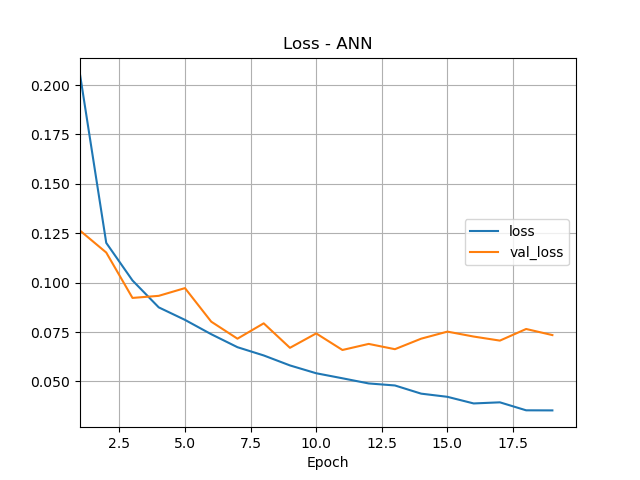

In [21]:
history_df_ann = pd.DataFrame(history_ann.history)
history_df_ann.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - ANN")
plt.legend(cols, loc="right")
plt.show()

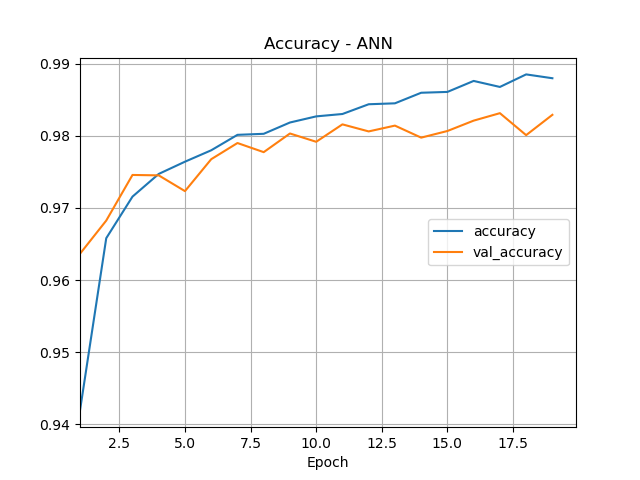

In [22]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - ANN")
plt.legend(cols, loc="right")
plt.show()

In [23]:
# Predict test set labels
y_pred_1  = model_ann.predict(X_test)
y_pred_ann = np.argmax(y_pred_1 , axis=1)

print('Accuracy of ANN: ', accuracy_score(y_test, y_pred_ann))

680/680 [==============================] - 1s 1ms/step
Accuracy of ANN:  0.9803037275655775


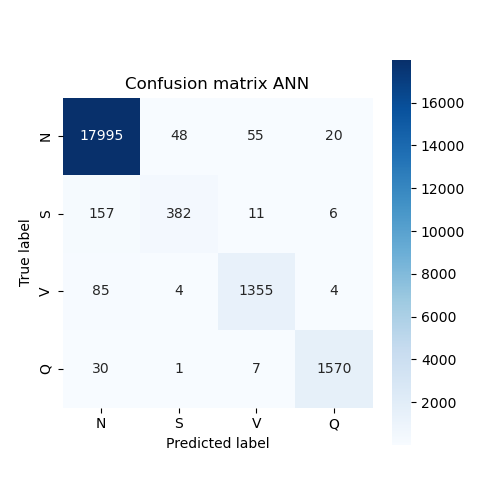

In [24]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ann)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix ANN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [25]:
print(classification_report(y_test, y_pred_ann, target_names=labels, digits=4))

                                   precision    recall  f1-score   support

                           Normal     0.9851    0.9932    0.9891     18118
                 Artial Premature     0.8782    0.6871    0.7709       556
Premature ventricular contraction     0.9489    0.9358    0.9423      1448
                            Paced     0.9812    0.9764    0.9788      1608

                         accuracy                         0.9803     21730
                        macro avg     0.9484    0.8981    0.9203     21730
                     weighted avg     0.9797    0.9803    0.9797     21730



### CNN

In [28]:
model_cnn = Sequential([
    Conv1D(64, kernel_size=6, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_cnn_5.h5', monitor='val_loss', save_best_only=True)]


history_cnn = model_cnn.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))

model_cnn.load_weights('best_cnn_5.h5')
save_model(model_cnn, 'Simple_CNN_MITBIH', 'keras')

Epoch 1/40
2173/2173 [==============================] - 46s 20ms/step - loss: 0.1162 - accuracy: 0.9670 - val_loss: 0.0703 - val_accuracy: 0.9787
Epoch 2/40
2173/2173 [==============================] - 44s 20ms/step - loss: 0.0633 - accuracy: 0.9811 - val_loss: 0.0622 - val_accuracy: 0.9814
Epoch 3/40
2173/2173 [==============================] - 41s 19ms/step - loss: 0.0496 - accuracy: 0.9850 - val_loss: 0.0639 - val_accuracy: 0.9812
Epoch 4/40
2173/2173 [==============================] - 41s 19ms/step - loss: 0.0405 - accuracy: 0.9873 - val_loss: 0.0736 - val_accuracy: 0.9788
Epoch 5/40
2173/2173 [==============================] - 45s 21ms/step - loss: 0.0353 - accuracy: 0.9891 - val_loss: 0.0747 - val_accuracy: 0.9803
Epoch 6/40
2173/2173 [==============================] - 43s 20ms/step - loss: 0.0310 - accuracy: 0.9899 - val_loss: 0.0610 - val_accuracy: 0.9815
Epoch 7/40
2173/2173 [==============================] - 41s 19ms/step - loss: 0.0259 - accuracy: 0.9918 - val_loss: 0.0689 -

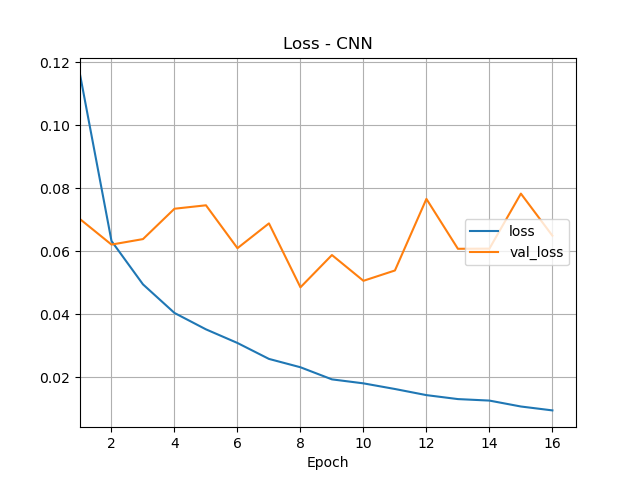

In [29]:
history_df_cnn = pd.DataFrame(history_cnn.history)
history_df_cnn.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - CNN")
plt.legend(cols, loc="right")
plt.show()

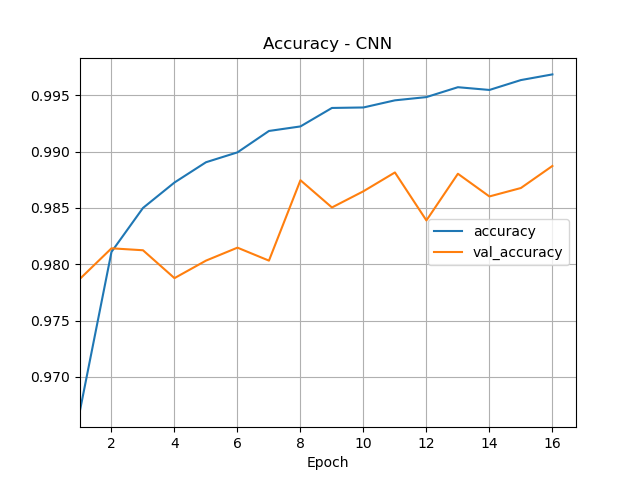

In [30]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - CNN")
plt.legend(cols, loc="right")
plt.show()

In [31]:
# Predict test set labels
y_pred_2  = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_2 , axis=1)

print('Accuracy of CNN: ', accuracy_score(y_test, y_pred_cnn))

680/680 [==============================] - 3s 4ms/step
Accuracy of CNN:  0.9861021629084216


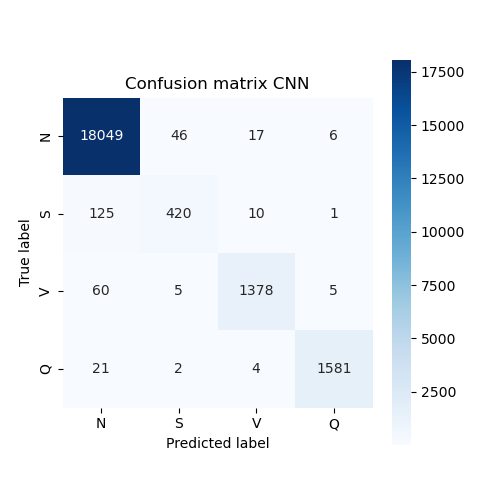

In [32]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix CNN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [33]:
print(classification_report(y_test, y_pred_cnn, target_names=labels, digits=4))

                                   precision    recall  f1-score   support

                           Normal     0.9887    0.9962    0.9924     18118
                 Artial Premature     0.8879    0.7554    0.8163       556
Premature ventricular contraction     0.9780    0.9517    0.9646      1448
                            Paced     0.9925    0.9832    0.9878      1608

                         accuracy                         0.9861     21730
                        macro avg     0.9618    0.9216    0.9403     21730
                     weighted avg     0.9857    0.9861    0.9857     21730

